# Predicting rate of death
The CDC [reports](https://www.kaggle.com/datasets/cdc/nchs-death-rates-and-causes-of-death) death rates in all US states due to various causes such as heart disease, Alzheimer's, etc.

This notebook is an effort to find the features which predict those rates. I am using [Census Bureau nonemployer establishment data](https://www.census.gov/programs-surveys/nonemployer-statistics/data/datasets.html#:~:text=Nonemployer%20Statistics%20Datasets,-Nonemployer%20Statistics%20(NES&text=NES%20data%20includes%20the%20number,geographic%20area%20and%20industry%20detail.) as my first attempt. A nonemployer estabishment is a business without any employees.

Death rates are measured as the number of deaths per 100,000 people.

The data is for year 2017.

This is a work-in-progress. I have gotten as far as:
* Preparing the feature set.
* Running a multiple linear regression for heart disease and [reaching a conclusion](#heart_disease_linear_regression_conclusion).
* Running a Naive Bayes analysis and not finding anything useful.
  * [try 1](#bayes_1)
  * [try 2](#bayes_2)
* Running [XGBoosted decision trees](#xgboost) and not finding anything useful.

## Data preparation

In [414]:
import collections
import csv
import datetime
import itertools
import math
import os
import pickle
import re
import subprocess
# Imports above are standard library
# Imports below are 3rd-party
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import recall_score, precision_score, silhouette_score, f1_score, accuracy_score, roc_auc_score, balanced_accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.model_selection import train_test_split, PredefinedSplit, GridSearchCV
from sklearn.naive_bayes import GaussianNB, BernoulliNB, CategoricalNB, ComplementNB, MultinomialNB
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.utils.class_weight import compute_sample_weight
from statsmodels.api import qqplot
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats
import statsmodels.api as sm
from xgboost import XGBClassifier, plot_importance

## Download credentials
You will need your own:

In [421]:
CENSUS_API_KEY = "your-key-here"

# Optional (you can download cause-of-death data from this repo):
MY_KAGGLE_USERNAME = "your-username-here"
MY_KAGGLE_KEY = "your-key-here"

### Cause of death data
You can use Kaggle to download this data or [take it from this repo](https://github.com/jsf80238/data_science/blob/main/data_files/nchs-leading-causes-of-death-united-states.csv).

#### Kaggle API
If you will be downloading from Kaggle you will need your own API key, which you can get by following [these instructions](https://github.com/Kaggle/kaggle-api/blob/main/docs/README.md).

In [309]:
KAGGLE_FILE_NAME = "nchs-leading-causes-of-death-united-states.csv"

save_file = "nchs-leading-causes-of-death-united-states.df"  # For larger downloads saving the dataframe locally can save time between runs

In [310]:
def get_kaggle_dataset_ref() -> str:
    os.environ["KAGGLE_USERNAME"] = MY_KAGGLE_USERNAME
    os.environ["KAGGLE_KEY"] = MY_KAGGLE_KEY
    import kaggle  # The import itself uses your KAGGLE_KEY, that's why the import is not at the top. Really.
    
    dataset_name = "NCHS - Death Rates and Causes of Death"
    command = "kaggle datasets list --csv --search".split()
    #command.append("NCHS - Death Rates and Causes of Death")
    result = subprocess.run(command + [dataset_name], capture_output=True)
    data = result.stdout.decode(encoding="utf-8")
    csvreader = csv.DictReader(data.splitlines())
    for row in csvreader:
        if row["title"] == dataset_name:
            # print(row)
            return row["ref"]
            break
    else:
        raise Exception("Could not find a matching Kaggle dataset.")


In [311]:
if os.path.exists(save_file):
    with open(save_file, "rb") as reader:
        df = pickle.load(reader)
else:
    dataset_ref = get_kaggle_dataset_ref()
    command = f"kaggle datasets download --unzip --force --file {KAGGLE_FILE_NAME} {dataset_ref}".split()
    result = subprocess.run(command, capture_output=True)
    stdout = result.stdout.decode(encoding="utf-8")
    stderr = result.stderr.decode(encoding="utf-8")
    print(stdout)
    print(stderr)
    print()
    print("Directory contents:")
    print(os.linesep.join(sorted(os.listdir("."))))
    print()
    df = pd.read_csv(KAGGLE_FILE_NAME)
    with open(save_file, "wb") as writer:
        pickle.dump(df, writer)

print("Dataframe details:")
print(f"{df.shape[0]:,} rows")
df.head(2)

Dataframe details:
10,868 rows


,Year,113 Cause Name,Cause Name,State,Deaths,Age-adjusted Death Rate
0,2012,"Nephritis, nephrotic syndrome and nephrosis (N...",Kidney disease,Vermont,21,2.6
1,2017,"Nephritis, nephrotic syndrome and nephrosis (N...",Kidney disease,Vermont,29,3.3


### Exploratory data analysis
Use [data profiling tool](https://github.com/jsf80238/data_science/blob/main/README.md) to do this.

Download this dataframe to CSV:
```
save_file = "nchs-leading-causes-of-death-united-states.csv"
with open(save_file, "w") as writer:
    writer.write(df.to_csv(index=False))
print(f"Wrote {os.stat(save_file).st_size} bytes to '{save_file}'.")
```
Analyze using the tool.
```
~/PycharmProjects/data_science $ python data_science/profile_data.py data_files/nchs-leading-causes-of-death-united-states.csv --tar=$HOME
```

Results below.

#### Summary

![summary](../images/death_rate/summary.png)

Of note above:
* Columns C & D tell us we have no nulls.
* Cells I2 and J2 tell us we have data from years 1999 to 2017.
* Cells E5, I5, J5 and K5 tell us we have all the states plus Washington DC. Actually we have one too many, we'll have to see why that is.
* Cells I7 & J7 say there is a very wide range for adjusted death rate, we'll have to see why that is.

#### Years

![summary](../images/death_rate/year_box.png)

(Looks good.)

#### Cause (of death)

![summary](../images/death_rate/cause_detail.png)

(Looks good.)

#### Death rate

![summary](../images/death_rate/death_rate_box.png)

Outliers. See below for what we do with those.

#### Duplicate data
Next, check for duplicate data.

In [312]:
df.duplicated().value_counts()

False    10868
Name: count, dtype: int64

In [313]:
### 52 states?

In [314]:
df["State"].value_counts().reset_index().sort_values(by=["State"])

,State,count
21,Alabama,209
39,Alaska,209
29,Arizona,209
51,Arkansas,209
37,California,209
50,Colorado,209
43,Connecticut,209
26,Delaware,209
1,District of Columbia,209
40,Florida,209


### Adjustments
The data includes rows for deaths for the entire United States, we don't want those.

Also, in case 2017 was an especially good or bad year, use the average from 2010-2017.

Also, drop unneeded columns.

In [315]:
name_dict = {
    "Year": "year",
    "Cause Name": "cause",
    "State": "state_name",
    "Age-adjusted Death Rate": "death_rate",
}
df.rename(columns=name_dict, inplace=True)

df.drop(columns=["113 Cause Name", "Deaths"], inplace=True)

mask = (df["year"] >= 2010) & (df["state_name"] != 'United States')
df = df[mask]

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4488 entries, 0 to 10802
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   year        4488 non-null   int64  
 1   cause       4488 non-null   object 
 2   state_name  4488 non-null   object 
 3   death_rate  4488 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 175.3+ KB


#### Ultimately we want death rate by state and cause

In [316]:
df = df[["state_name", "cause", "death_rate"]].groupby(["state_name", "cause"]).mean().reset_index()
df

,state_name,cause,death_rate
0,Alabama,All causes,924.6125
1,Alabama,Alzheimer's disease,35.2625
2,Alabama,CLRD,55.5750
3,Alabama,Cancer,180.5125
4,Alabama,Diabetes,22.6875
...,...,...,...
556,Wyoming,Influenza and pneumonia,17.5750
557,Wyoming,Kidney disease,11.7625
558,Wyoming,Stroke,33.2625
559,Wyoming,Suicide,24.6750


### Add a normalized death rate
A state may have a higher death rate across-the-board, or may have a higher death rate for particular causes, or both.

Divide the death rates for particular causes by the death rate for that state to better isolate particular causes.

In [317]:
death_rate_all_causes = "death_rate_all_causes"
all_causes = "All causes"
mask = (df["cause"] == all_causes)
by_state_df = df[mask][["state_name", "death_rate"]]
print(f"{by_state_df.shape[0]:,} rows")
by_state_df.head(2)

51 rows


,state_name,death_rate
0,Alabama,924.6125
11,Alaska,739.2125


In [318]:
df = df.merge(by_state_df, on="state_name", suffixes=(None, "_all_causes"))
df["death_rate_normalized"] = df["death_rate"] / df[death_rate_all_causes]
df.drop(columns=[death_rate_all_causes], inplace=True)
print(f"{df.shape[0]:,} rows")
df.head(2)

561 rows


,state_name,cause,death_rate,death_rate_normalized
0,Alabama,All causes,924.6125,1.000000
1,Alabama,Alzheimer's disease,35.2625,0.038138


#### We don't need all-causes rows anymore

In [319]:
mask = (df["cause"] != all_causes)
df = df[mask]
print(f"{df.shape[0]:,} rows")
df.head(2)

510 rows


,state_name,cause,death_rate,death_rate_normalized
1,Alabama,Alzheimer's disease,35.2625,0.038138
2,Alabama,CLRD,55.5750,0.060106


### Census data: state populations

In [320]:
CENSUS_API_KEY = "35b2edd7f868b6d6f79e5988091d0f8df6ffbd2a"

In [321]:
CENSUS_DEMOGRAPHICS_URL = "https://api.census.gov/data/2019/pep/charagegroups"
param_dict = {'get': 'NAME,POP', 'for': 'state:*', "key": CENSUS_API_KEY}

In [322]:
response = requests.get(CENSUS_DEMOGRAPHICS_URL, params=param_dict)

In [323]:
result_list = response.json()  # The return from the API call is a list of lists, with first item being the column names
column_name_list = result_list.pop(0)
states_df = pd.DataFrame(result_list, columns=column_name_list)
states_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   NAME    52 non-null     object
 1   POP     52 non-null     object
 2   state   52 non-null     object
dtypes: object(3)
memory usage: 1.3+ KB


In [324]:
name_dict = {
    "NAME": "state_name",
    "POP": "population",
    "state": "state_key",
}
states_df.rename(columns=name_dict, inplace=True)
states_df["population"] = states_df["population"].astype(int)
states_df["state_key"] = states_df["state_key"].astype(int)
states_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   state_name  52 non-null     object
 1   population  52 non-null     int64 
 2   state_key   52 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.3+ KB


In [325]:
states_df["population"].sum()  # Expected value ~330 million

331433217

In [326]:
df = df.merge(states_df, on="state_name", how="inner")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510 entries, 0 to 509
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   state_name             510 non-null    object 
 1   cause                  510 non-null    object 
 2   death_rate             510 non-null    float64
 3   death_rate_normalized  510 non-null    float64
 4   population             510 non-null    int64  
 5   state_key              510 non-null    int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 24.0+ KB


### Census data: non-employer data
Nonemployer Statistics provides annual statistics on U.S. businesses with no paid employees or payroll at a detailed geography and industry level.

Statistics are available on businesses that have no paid employment or payroll, are subject to federal income taxes, and have receipts of \\$1,000 or more (\\$1 or more for the Construction sector). The data are available for approximately 450 NAICS industries at the national, state, county, metropolitan statistical area, and combined statistical area geography levels. The majority of NAICS industries are included.

https://www.census.gov/data/developers/data-sets/nonemp-api.2017.html#list-tab-1358655114

https://www.census.gov/data/developers/data-sets/nonemp-api.html
https://api.census.gov/data/2017/nonemp/variables.html

https://www2.census.gov/programs-surveys/nonemployer-statistics/technical-documentation/record-layouts/state-record-layout/state_record_layout_2017.txt

#### Definitions
* LFO = Legal form of organization
* NAICS2017_LABEL = type of business
* NAME = geo areas, including states
* NESTAB = Number of nonemployer establishments
* NRCPTOT = Nonemployer sales, value of shipments, or revenue ($1,000)
* RCPSZES_LABEL = Separates establishments into groups by sales/receipts, including "All establishments"

In [327]:
CENSUS_NONEMPLOYER_URL = "https://api.census.gov/data/2017/nonemp"
param_dict = {'get': ','.join(("LFO", "NESTAB", "NRCPTOT")), 'for': 'state:*', "NAICS2017": '*', "key": CENSUS_API_KEY}

save_file = "census.df"  # For larger downloads saving the dataframe locally can save time between runs

In [328]:
# This cell may take a minute or two if you have not already downloaded the data
if os.path.exists(save_file):
    with open(save_file, "rb") as reader:
        business_df = pickle.load(reader)
else:
    response = requests.get(CENSUS_NONEMPLOYER_URL, params=param_dict)
    result_list = response.json()  # The return from the API call is a list of lists, with first item being the column names
    column_name_list = result_list.pop(0)
    business_df = pd.DataFrame(result_list, columns=column_name_list)
    with open(save_file, "wb") as writer:
        pickle.dump(business_df, writer)

print("Dataframe details:")
print(f"{business_df.shape[0]:,} rows")
business_df.head(2)

Dataframe details:
109,381 rows


,LFO,NESTAB,NRCPTOT,NAICS2017,state
0,001,219596,8889009,00,28
1,9101,1750,206357,00,28


### Exploratory data analysis
Download this dataframe to CSV:
```
save_file = "nonemployee-data.csv"
with open(save_file, "w") as writer:
    writer.write(business_df.to_csv(index=False))
print(f"Wrote {os.stat(save_file).st_size} bytes to '{save_file}'.")
```
Use the [data profiling tool](https://github.com/jsf80238/data_science/blob/main/README.md).
```
~/PycharmProjects/data_science $ python data_science/profile_data.py data_files/nonemployee-data.csv --tar=$HOME
```

Results below.

#### Summary

![summary](../images/death_rate/non_employer_summary.png)

Of note above:
* Cell E2 tells us we have 51 states ... might be 50 plus DC, might be 50 plus United States, we'll have to check.
* The _largest_, _smallest_, _mean_ and _standard deviation_ measures for the number of establishments and total receipts show abnormally large values.

#### State

![summary](../images/death_rate/non_employer_state.png)

The _value_ column contains the state ID ... refer to [this cell](#states_by_id) for the lookup. We still have to verify we have the correct 51.

#### Legal Form of Establishment

![summary](../images/death_rate/non_employer_legal_form.png)

Roughly an even split, which is not unreasonable. The [lookup table](../data_files/legal_form_codes.csv) tells us we will need to remove the _1.0/All_ rows.

#### Number of establishments

![summary](../images/death_rate/non_employer_number_of_establishments.png)

There are a lot with a value of 0, but probably reasonable that in a given state there might be zero such establishments for certain combinations of legal form and business type (for example, 486110/Pipeline Transportation of Crude Oil in Rhode Island).

#### Revenue

![summary](../images/death_rate/non_employer_revenue.png)

Outliers, will need to investigate that.

#### NAICS code

![summary](../images/death_rate/non_employer_naics_code.png)

The [lookup table](../data_files/naics_codes.csv) tells us the NAICS codes will be 2, 3, 4, 5 or 6 digits depending on the level in the hierarchy, but the pattern breakdown from the actual data shows some codes which are not all digits: `99?99`. We will need to investigate that.

#### Duplicate data
Next, check for duplicate data.

In [329]:
business_df.duplicated().value_counts()

False    109381
Name: count, dtype: int64

### Cleanup
* Give columns better names
* Convert numeric-like values to numerics

In [330]:
name_dict = {
    "state": "state_key",
    "NAICS2017": "business_type",
    "LFO": "legal_form",
    "NESTAB": "establishment_count",
    "NRCPTOT": "revenue_in_thousands",
}
business_df.rename(columns=name_dict, inplace=True)
business_df = business_df.reindex(["state_key", "legal_form", "business_type", "establishment_count", "revenue_in_thousands"], axis=1)

for column_name in "establishment_count", "revenue_in_thousands", "state_key":
    business_df[column_name] = business_df[column_name].astype(int)
business_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109381 entries, 0 to 109380
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   state_key             109381 non-null  int64 
 1   legal_form            109381 non-null  object
 2   business_type         109381 non-null  object
 3   establishment_count   109381 non-null  int64 
 4   revenue_in_thousands  109381 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 4.2+ MB


#### Revenue and number of establishments outliers

In [331]:
business_df["revenue_in_thousands"].value_counts().reset_index().sort_values(by="revenue_in_thousands").tail()

,revenue_in_thousands,count
30526,92939642,1
15550,98320439,1
16343,118091482,1
37006,118273287,1
16328,181655457,1


In [332]:
mask = (business_df["revenue_in_thousands"] >= 118273287)
business_df[mask]

,state_key,legal_form,business_type,establishment_count,revenue_in_thousands
40560,48,001,00,2399267,118273287
66056,6,001,00,3374050,181655457


#### Eliminate summary rows
Rows where the legal_form is '001' or the business_type is '00' are summaries of the other rows, we don't want them.

In [333]:
mask = (business_df["legal_form"] != "001") & (business_df["business_type"] != '00')
business_df = business_df[mask]
business_df.shape

(85351, 5)

#### NAICS codes unexpected data
Our exploratory data analysis showed rows where the NAICS code (now named _business_type_ was of the form:

`digit digit something digit digit`

whereas we expected all digits.

In [334]:
mask = (business_df["business_type"].str.isnumeric())
business_df[~mask]

,state_key,legal_form,business_type,establishment_count,revenue_in_thousands
245,28,9101,31-33,52,5329
246,28,9111,31-33,150,17001
247,28,920,31-33,2286,73289
248,28,930,31-33,134,13047
630,28,9101,44-45,147,23219
...,...,...,...,...,...
107834,27,930,44-45,1326,129953
108256,27,9101,48-49,204,33435
108257,27,9111,48-49,802,122804
108258,27,920,48-49,32370,1711368


### Census codes
It will be helpful for further analysis to be able to view the legal form codes and business type codes as strings rather than codes.

I've gone to the trouble of downloading these, because the Census people don't make this information easy to work with (see the Original links below).
* North American Industry Classification System (aka NAIC)
  * [Original](https://www.census.gov/naics/?58967?yearbck=2017)
  * [Version used here](https://github.com/jsf80238/data_science/blob/main/data_files/naics_codes.csv)
* Legal Form of Organization
  * [Original](https://www2.census.gov/programs-surveys/abs/technical-documentation/api/NESD-Technical-Employer-and-Nonemployer-API-5242022Final.pdf)
  * [Version used here](https://github.com/jsf80238/data_science/blob/main/data_files/legal_form_codes.csv)

In [335]:
def reformat_column_name(s: str) -> str:
    s = re.sub(r"\W", "_", s)
    s = s.replace("__", "_")
    s = re.sub(r"_$", "", s)
    return s.lower()


BUSINESS_TYPE_URL = "https://raw.githubusercontent.com/jsf80238/data_science/main/data_files/naics_codes.csv"
response = requests.get(BUSINESS_TYPE_URL)
line_list = response.text.splitlines()

business_type_dict = dict()
csvreader = csv.DictReader(line_list)
label_for_keys, label_for_values = csvreader.fieldnames
for row in csvreader:
    nominal_label = row[label_for_values]
    improved_label = reformat_column_name(nominal_label)
    business_type_dict[row[label_for_keys]] = improved_label


LEGAL_FORM_URL = "https://raw.githubusercontent.com/jsf80238/data_science/main/data_files/legal_form_codes.csv"
response = requests.get(LEGAL_FORM_URL)
line_list = response.text.splitlines()

legal_form_dict = dict()
csvreader = csv.DictReader(line_list)
label_for_keys, label_for_values = csvreader.fieldnames
for row in csvreader:
    nominal_label = row[label_for_values]
    improved_label = reformat_column_name(nominal_label)
    legal_form_dict[row[label_for_keys]] = improved_label


In [336]:
for key, value in business_type_dict.items():
    if "-" in key:
        print(key, value)


31-33 manufacturing
44-45 retail_trade
48-49 transportation_and_warehousing


In [337]:
# Verify there are no rows with a code of 31, 32, 33, 44, 45, 48 or 49
mask = (business_df["business_type"].isin((31, 32, 33, 44, 45, 48, 49)))
business_df[mask].shape

(0, 5)

There are none.

### Keep only the useful business type rows
The Census data contains rows for multiple levels, some of which are summaries of levels below, for example:
| Code | Name |
| --- | --- |
| 11 | Agriculture, Forestry, Fishing and Hunting |
| 111 | Crop Production |
| 1111 | Oilseed and Grain Farming |
| 11111 | Soybean Farming |
| 111110 | Soybean Farming |
| 11112 | Oilseed (except Soybean) Farming |
| 111120 | Oilseed (except Soybean) Farming |
| 11113 | Dry Pea and Bean Farming |
| 111130 | Dry Pea and Bean Farming |
| ... | ... |
| 115210 | Support Activities for Animal Production |
| 1153 | Support Activities for Forestry |
| 11531 | Support Activities for Forestry |
| 115310 | Support Activities for Forestry |
| 21 | Mining |  Quarrying |  and Oil and Gas Extraction |
| 211 | Oil and Gas Extraction |
| 2111 | Oil and Gas Extraction |
| 21112 | Crude Petroleum Extraction  |

Although somewhat arbitrary, the 2-digit codes make the most sense to me.

And we need to include codes with dashes, because those will be treated as two-digit codes.

In [338]:
mask = (business_df["business_type"].str.len() == 2) | (business_df["business_type"].str.contains("-"))
business_df = business_df[mask]
print(business_df.shape)
business_df.head(2)

(3665, 5)


,state_key,legal_form,business_type,establishment_count,revenue_in_thousands
6,28,9101,11,77,10091
7,28,9111,11,176,20417


#### Check for duplicates

In [339]:
mask = business_df[["state_key", "business_type", "legal_form"]].duplicated()
business_df[mask]

,state_key,legal_form,business_type,establishment_count,revenue_in_thousands


### Check for holes
Verify this data does not have holes, meaning verify every combination of legal_form/business_type exists for every state.

If something is missing, add it with np.nan for the establishment_count and revenue.

In [340]:
state_list = business_df["state_key"].unique()
legal_form_list = business_df["legal_form"].unique()
business_type_list = business_df["business_type"].unique()
wanted_combinations_set = set(itertools.product(state_list, legal_form_list, business_type_list))
print(f"{len(wanted_combinations_set):,} possible combinations, for example:")
for i, item in enumerate(wanted_combinations_set):
    print(item)
    if i > 10:
        break


3,672 possible combinations, for example:
(13, '930', '81')
(20, '9111', '23')
(34, '920', '54')
(41, '9111', '21')
(8, '9101', '61')
(41, '9111', '22')
(40, '9101', '62')
(31, '930', '81')
(55, '930', '56')
(12, '9101', '48-49')
(18, '9111', '31-33')
(1, '9101', '11')


In [341]:
existing_combinations_set = set()
for item in business_df[["state_key", "legal_form", "business_type"]].to_records(index=False):
    existing_combinations_set.add(tuple(item))
print(f"{len(existing_combinations_set):,} existing combinations, for example:")
for i, item in enumerate(existing_combinations_set):
    print(item)
    if i > 10:
        break

3,665 existing combinations, for example:
(13, '930', '81')
(20, '9111', '23')
(34, '920', '54')
(41, '9111', '21')
(8, '9101', '61')
(41, '9111', '22')
(40, '9101', '62')
(31, '930', '81')
(55, '930', '56')
(12, '9101', '48-49')
(18, '9111', '31-33')
(1, '9101', '11')


In [342]:
missing_combinations_set = wanted_combinations_set - existing_combinations_set
print(f"{len(missing_combinations_set):,} missing combinations, for example:")
for i, item in enumerate(missing_combinations_set):
    print(item)
    if i > 10:
        break

7 missing combinations, for example:
(11, '9111', '21')
(11, '930', '21')
(2, '9111', '22')
(44, '9101', '21')
(11, '9101', '21')
(11, '9111', '11')
(11, '9101', '22')


In [343]:
missing_data = [list(combo) + [np.nan, np.nan] for combo in missing_combinations_set]
missing_data[:10]

[[11, '9111', '21', nan, nan],
 [11, '930', '21', nan, nan],
 [2, '9111', '22', nan, nan],
 [44, '9101', '21', nan, nan],
 [11, '9101', '21', nan, nan],
 [11, '9111', '11', nan, nan],
 [11, '9101', '22', nan, nan]]

In [344]:
missing_df = pd.DataFrame.from_records(missing_data)
missing_df.columns = ["state_key", "legal_form", "business_type", "establishment_count", "revenue_in_thousands"]
missing_df

,state_key,legal_form,business_type,establishment_count,revenue_in_thousands
0,11,9111,21,NaN,NaN
1,11,930,21,NaN,NaN
2,2,9111,22,NaN,NaN
3,44,9101,21,NaN,NaN
4,11,9101,21,NaN,NaN
5,11,9111,11,NaN,NaN
6,11,9101,22,NaN,NaN


In [345]:
business_df = pd.concat([business_df, missing_df], ignore_index=True)
business_df

,state_key,legal_form,business_type,establishment_count,revenue_in_thousands
0,28,9101,11,77.0,10091.0
1,28,9111,11,176.0,20417.0
2,28,920,11,3692.0,165982.0
3,28,930,11,182.0,19481.0
4,28,9101,21,20.0,1993.0
...,...,...,...,...,...
3667,2,9111,22,NaN,NaN
3668,44,9101,21,NaN,NaN
3669,11,9101,21,NaN,NaN
3670,11,9111,11,NaN,NaN


### Merge cause of death data with business data

In [346]:
df = df.merge(business_df, on="state_key", how="inner")
print(f"{df.shape[0]:,} rows")
df.head(2)

36,720 rows


,state_name,cause,death_rate,death_rate_normalized,population,state_key,legal_form,business_type,establishment_count,revenue_in_thousands
0,Alabama,Alzheimer's disease,35.2625,0.038138,4903185,1,9101,11,30.0,4246.0
1,Alabama,Alzheimer's disease,35.2625,0.038138,4903185,1,9111,11,146.0,27390.0


### Adjust for population
We would expect the number of establishments and revenue to be higher in more populous states.

Adjust.

In [347]:
df["establishments_per_person"] = df["establishment_count"] / df["population"]
df["revenue_per_person"] = df["revenue_in_thousands"] * 1000 / df["population"]
df["revenue_per_establishment"] = df["revenue_in_thousands"] * 1000 / df["establishment_count"]
print(f"{df.shape[0]:,} rows")
df.head(2)

36,720 rows


,state_name,cause,death_rate,death_rate_normalized,population,state_key,legal_form,business_type,establishment_count,revenue_in_thousands,establishments_per_person,revenue_per_person,revenue_per_establishment
0,Alabama,Alzheimer's disease,35.2625,0.038138,4903185,1,9101,11,30.0,4246.0,0.000006,0.865968,141533.333333
1,Alabama,Alzheimer's disease,35.2625,0.038138,4903185,1,9111,11,146.0,27390.0,0.000030,5.586165,187602.739726


### Census codes
Up to now we've been using the census codes for
* business_type (e.g. '111' is "Crop Production") ... a/k/a NAIC code
* legal_form (e.g. '920' is "Individual Proprietor")

Convert these to the human-readable label.

In [348]:
df["legal_form"] = df["legal_form"].apply(lambda x: legal_form_dict.get(x))
print(f"{df.shape[0]:,} rows")

df["business_type"] = df["business_type"].apply(lambda x: business_type_dict.get(x))
print(f"{df.shape[0]:,} rows")

df.head(2)

36,720 rows
36,720 rows


,state_name,cause,death_rate,death_rate_normalized,population,state_key,legal_form,business_type,establishment_count,revenue_in_thousands,establishments_per_person,revenue_per_person,revenue_per_establishment
0,Alabama,Alzheimer's disease,35.2625,0.038138,4903185,1,c_corp,agriculture_forestry_fishing_and_hunting,30.0,4246.0,0.000006,0.865968,141533.333333
1,Alabama,Alzheimer's disease,35.2625,0.038138,4903185,1,s_corp,agriculture_forestry_fishing_and_hunting,146.0,27390.0,0.000030,5.586165,187602.739726


### More cleanup
* Scale numeric features.
* Convert legal_form and business_type to Pandas categories.
* Encode the categorical data to 0/1:
  * Legal form
  * Business type
  * Population
  * Establishments
  * Revenue


#### Scaling
See https://www.simplilearn.com/normalization-vs-standardization-article.
* Normalization: centered on 0 with standard deviation of 1 (and no effect on outliers).
* Standardization: lowest/highest values become 0 and 1.

In [349]:
scaling_df = pd.DataFrame()

numeric_column_list = df.select_dtypes(include=["float64", "int64"]).columns
to_be_scaled_column_list = [x for x in numeric_column_list if not x.startswith("death")]
for column_name in to_be_scaled_column_list:
        scaling_df[column_name] = df[column_name].copy()

scaler = MinMaxScaler()
scaling_df = pd.DataFrame(scaler.fit_transform(scaling_df), columns=to_be_scaled_column_list)

scaling_df

,population,state_key,establishment_count,revenue_in_thousands,establishments_per_person,revenue_per_person,revenue_per_establishment
0,0.111072,0.0,0.000058,0.000155,0.000278,0.000745,0.314685
1,0.111072,0.0,0.000282,0.001001,0.001355,0.004803,0.423155
2,0.111072,0.0,0.007839,0.005528,0.037611,0.026535,0.069375
3,0.111072,0.0,0.000348,0.001066,0.001671,0.005117,0.363148
4,0.111072,0.0,0.000012,0.000008,0.000056,0.000039,0.068954
...,...,...,...,...,...,...,...
36715,0.000000,1.0,0.000186,0.000436,0.007549,0.017739,0.274310
36716,0.000000,1.0,0.000112,0.000138,0.004561,0.005603,0.134569
36717,0.000000,1.0,0.000298,0.000469,0.012110,0.019073,0.177740
36718,0.000000,1.0,0.011192,0.004670,0.454913,0.189908,0.033475


#### Add scaled columns to master dataframe

In [350]:
df = df.merge(scaling_df, left_index=True, right_index=True, suffixes=(None, "_scaled"))
print(f"{df.shape[0]:,} rows")
df.head(2)

36,720 rows


,state_name,cause,death_rate,death_rate_normalized,population,state_key,legal_form,business_type,establishment_count,revenue_in_thousands,establishments_per_person,revenue_per_person,revenue_per_establishment,population_scaled,state_key_scaled,establishment_count_scaled,revenue_in_thousands_scaled,establishments_per_person_scaled,revenue_per_person_scaled,revenue_per_establishment_scaled
0,Alabama,Alzheimer's disease,35.2625,0.038138,4903185,1,c_corp,agriculture_forestry_fishing_and_hunting,30.0,4246.0,0.000006,0.865968,141533.333333,0.111072,0.0,0.000058,0.000155,0.000278,0.000745,0.314685
1,Alabama,Alzheimer's disease,35.2625,0.038138,4903185,1,s_corp,agriculture_forestry_fishing_and_hunting,146.0,27390.0,0.000030,5.586165,187602.739726,0.111072,0.0,0.000282,0.001001,0.001355,0.004803,0.423155


#### Categorization

### Create revenue and establishments by legal form and business type
For example, suppose we have a row with these values:
* `establishments_per_person_scaled` = 0.123
* `revenue_per_establishment_scaled` = 0.456
* `legal_form` = 'c_corp'
* `business_type` = 'chemical_manufacturing'

That row will be updated to contain for example these columns (and many more columns for the many different legal forms and business types:
| air_transportation_</br>establishments_</br>per_person | air_transportation_</br>revenue_per_</br>establishment | chemical_manufacturing_</br>establishments_</br>per_person | chemical_manufacturing_</br>revenue_per_</br>establishment | gasoline_stations_</br>establishments_</br>per_person | gasoline_stations_</br>revenue_per_</br>establishment | c_corp_</br>establishments_</br>per_person | c_corp_</br>revenue_per_</br>establishment | partnership_</br>establishments_</br>per_person | partnership_</br>revenue_per_</br>establishment | 
| - | - | - | - | - | - | - | - | - | - |
| 0 | 0 | 0.123 | 0.456 | 0 | 0 | 0.123 | 0.456 | 0 | 0 |

In [351]:
df = pd.get_dummies(df, columns=["legal_form", "business_type"], dtype=int)
df.head(2)

,state_name,cause,death_rate,death_rate_normalized,population,state_key,establishment_count,revenue_in_thousands,establishments_per_person,revenue_per_person,...,business_type_information,business_type_manufacturing,business_type_mining_quarrying_and_oil_and_gas_extraction,business_type_other_services_except_public_administration,business_type_professional_scientific_and_technical_services,business_type_real_estate_and_rental_and_leasing,business_type_retail_trade,business_type_transportation_and_warehousing,business_type_utilities,business_type_wholesale_trade
0,Alabama,Alzheimer's disease,35.2625,0.038138,4903185,1,30.0,4246.0,0.000006,0.865968,...,0,0,0,0,0,0,0,0,0,0
1,Alabama,Alzheimer's disease,35.2625,0.038138,4903185,1,146.0,27390.0,0.000030,5.586165,...,0,0,0,0,0,0,0,0,0,0


#### Add columns

In [352]:
establishments_per_person = "establishments_per_person"
revenue_per_establishment = "revenue_per_establishment"
business_type = "business_type"
legal_form = "legal_form"
scaled = "scaled"

column_list = list(df.columns)
legal_form_list = [x for x in column_list if x.startswith(legal_form)]
business_type_list = [x for x in column_list if x.startswith(business_type)]

In [353]:
for item in legal_form_list:
    establishments_column_name = item + "_" + establishments_per_person
    df[establishments_column_name] = df[establishments_per_person + "_" + scaled] * df[item]
    revenue_column_name = item + "_" + revenue_per_establishment
    df[revenue_column_name] = df[revenue_per_establishment + "_" + scaled] * df[item]

In [354]:
for item in business_type_list:
    establishments_column_name = item + "_" + establishments_per_person
    df[establishments_column_name] = df[establishments_per_person + "_" + scaled] * df[item]
    revenue_column_name = item + "_" + revenue_per_establishment
    df[revenue_column_name] = df[revenue_per_establishment + "_" + scaled] * df[item]

#### Performance warning & cleanup
We'll take care of the `PerformanceWarning: DataFrame is highly fragmented.` warning in a bit. See https://stackoverflow.com/questions/68292862/performancewarning-dataframe-is-highly-fragmented-this-is-usually-the-result-o.

In the meantime, we no longer need the "dummies" columns, for example:
* legal_form_s_corp
* business_type_accommodation

In [355]:
columns_to_drop_list = list()
for column_name in df.columns:
    if column_name.startswith(legal_form) or column_name.startswith(business_type):
        if not column_name.endswith(establishments_per_person) and not column_name.endswith(revenue_per_establishment):
            columns_to_drop_list.append(column_name)
df.drop(columns=columns_to_drop_list, inplace=True)
print(df.info())
df.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36720 entries, 0 to 36719
Data columns (total 62 columns):
 #   Column                                                                                                            Non-Null Count  Dtype  
---  ------                                                                                                            --------------  -----  
 0   state_name                                                                                                        36720 non-null  object 
 1   cause                                                                                                             36720 non-null  object 
 2   death_rate                                                                                                        36720 non-null  float64
 3   death_rate_normalized                                                                                             36720 non-null  float64
 4   population                  

,state_name,cause,death_rate,death_rate_normalized,population,state_key,establishment_count,revenue_in_thousands,establishments_per_person,revenue_per_person,...,business_type_real_estate_and_rental_and_leasing_establishments_per_person,business_type_real_estate_and_rental_and_leasing_revenue_per_establishment,business_type_retail_trade_establishments_per_person,business_type_retail_trade_revenue_per_establishment,business_type_transportation_and_warehousing_establishments_per_person,business_type_transportation_and_warehousing_revenue_per_establishment,business_type_utilities_establishments_per_person,business_type_utilities_revenue_per_establishment,business_type_wholesale_trade_establishments_per_person,business_type_wholesale_trade_revenue_per_establishment
0,Alabama,Alzheimer's disease,35.2625,0.038138,4903185,1,30.0,4246.0,0.000006,0.865968,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Alabama,Alzheimer's disease,35.2625,0.038138,4903185,1,146.0,27390.0,0.000030,5.586165,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [356]:
# Address performance warning
temp_df = df.copy()
df = temp_df.copy()
del(temp_df)
print(f"{df.shape[0]:,} rows")
df.head(2)

36,720 rows


,state_name,cause,death_rate,death_rate_normalized,population,state_key,establishment_count,revenue_in_thousands,establishments_per_person,revenue_per_person,...,business_type_real_estate_and_rental_and_leasing_establishments_per_person,business_type_real_estate_and_rental_and_leasing_revenue_per_establishment,business_type_retail_trade_establishments_per_person,business_type_retail_trade_revenue_per_establishment,business_type_transportation_and_warehousing_establishments_per_person,business_type_transportation_and_warehousing_revenue_per_establishment,business_type_utilities_establishments_per_person,business_type_utilities_revenue_per_establishment,business_type_wholesale_trade_establishments_per_person,business_type_wholesale_trade_revenue_per_establishment
0,Alabama,Alzheimer's disease,35.2625,0.038138,4903185,1,30.0,4246.0,0.000006,0.865968,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Alabama,Alzheimer's disease,35.2625,0.038138,4903185,1,146.0,27390.0,0.000030,5.586165,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [357]:
drop_column_list = [
    "state_name",
    # "population",
    "establishments_per_person",
    "revenue_per_establishment",
]
temp_df = df.copy()
temp_df.drop(columns=drop_column_list, inplace=True)
lin_reg_df = temp_df.groupby(["cause", "population", "death_rate", "death_rate_normalized"]).sum().reset_index()
lin_reg_df

,cause,population,death_rate,death_rate_normalized,state_key,establishment_count,revenue_in_thousands,revenue_per_person,population_scaled,state_key_scaled,...,business_type_real_estate_and_rental_and_leasing_establishments_per_person,business_type_real_estate_and_rental_and_leasing_revenue_per_establishment,business_type_retail_trade_establishments_per_person,business_type_retail_trade_revenue_per_establishment,business_type_transportation_and_warehousing_establishments_per_person,business_type_transportation_and_warehousing_revenue_per_establishment,business_type_utilities_establishments_per_person,business_type_utilities_revenue_per_establishment,business_type_wholesale_trade_establishments_per_person,business_type_wholesale_trade_revenue_per_establishment
0,Alzheimer's disease,578759,25.2625,0.034026,4032,51309.0,2552793.0,4410.804843,0.000000,72.000000,...,0.638608,0.677056,0.405765,0.970442,0.150432,1.136622,0.004010,0.647892,0.058899,1.107499
1,Alzheimer's disease,623989,34.6500,0.048823,3600,61504.0,2653651.0,4252.720801,0.083644,64.145455,...,0.422595,0.838036,0.372706,0.784850,0.118668,0.907610,0.008679,0.626771,0.061048,1.167174
2,Alzheimer's disease,705749,19.0000,0.025160,792,61345.0,3050260.0,4322.018168,0.234844,13.090909,...,0.368995,1.019488,0.121429,0.954979,0.471271,0.912004,0.002644,0.712351,0.018250,1.279470
3,Alzheimer's disease,731545,21.7875,0.029474,144,56796.0,2672227.0,3652.853891,0.282549,1.309091,...,0.326245,0.880360,0.316602,0.986950,0.182969,0.919840,0.001866,0.513574,0.034466,0.900660
4,Alzheimer's disease,762062,37.0750,0.053124,2736,55315.0,2757372.0,3618.304023,0.338984,48.436364,...,0.461947,0.879698,0.391356,0.895772,0.210101,1.122934,0.002031,1.046414,0.044075,0.956260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,Unintentional injuries,12801989,50.7750,0.066283,3024,849036.0,41274856.0,3224.097131,22.604528,53.672727,...,0.332336,0.849936,0.296384,0.892937,0.238479,1.039105,0.001991,0.843433,0.047787,1.172121
506,Unintentional injuries,19453561,29.1625,0.045064,2592,1751378.0,92939642.0,4777.513073,34.905339,45.818182,...,0.487225,1.031175,0.278354,0.890067,0.445348,0.793400,0.002056,0.971753,0.075288,1.247874
507,Unintentional injuries,21477737,45.3375,0.067478,864,2245127.0,98320439.0,4577.783916,38.648665,14.400000,...,0.581100,0.674140,0.321768,0.870698,0.447462,0.911380,0.002002,0.855001,0.084754,1.141346
508,Unintentional injuries,28995881,38.0250,0.050824,3456,2399267.0,118273287.0,4078.968561,52.552036,61.527273,...,0.322146,0.944199,0.308354,1.009625,0.329986,1.359840,0.002927,1.061917,0.053823,1.345816


### Create different frames for each cause of death
The features leading to a higher death rate might be different based on cause of death.

We will analyze each separately.

In [358]:
frames_by_cause_dict = dict()
for cause_name in lin_reg_df["cause"].unique():
    mask = (lin_reg_df["cause"] == cause_name)
    new_df = lin_reg_df[mask].copy()
    new_df.drop(columns=["cause"], inplace=True)
    frames_by_cause_dict[cause_name] = new_df

frames_by_cause_dict["Heart disease"]

,population,death_rate,death_rate_normalized,state_key,establishment_count,revenue_in_thousands,revenue_per_person,population_scaled,state_key_scaled,establishment_count_scaled,...,business_type_real_estate_and_rental_and_leasing_establishments_per_person,business_type_real_estate_and_rental_and_leasing_revenue_per_establishment,business_type_retail_trade_establishments_per_person,business_type_retail_trade_revenue_per_establishment,business_type_transportation_and_warehousing_establishments_per_person,business_type_transportation_and_warehousing_revenue_per_establishment,business_type_utilities_establishments_per_person,business_type_utilities_revenue_per_establishment,business_type_wholesale_trade_establishments_per_person,business_type_wholesale_trade_revenue_per_establishment
204,578759,159.5750,0.214930,4032,51309.0,2552793.0,4410.804843,0.000000,72.000000,0.099266,...,0.638608,0.677056,0.405765,0.970442,0.150432,1.136622,0.004010,0.647892,0.058899,1.107499
205,623989,153.2375,0.215919,3600,61504.0,2653651.0,4252.720801,0.083644,64.145455,0.118990,...,0.422595,0.838036,0.372706,0.784850,0.118668,0.907610,0.008679,0.626771,0.061048,1.167174
206,705749,205.0250,0.271498,792,61345.0,3050260.0,4322.018168,0.234844,13.090909,0.118683,...,0.368995,1.019488,0.121429,0.954979,0.471271,0.912004,0.002644,0.712351,0.018250,1.279470
207,731545,143.6625,0.194345,144,56796.0,2672227.0,3652.853891,0.282549,1.309091,0.109882,...,0.326245,0.880360,0.316602,0.986950,0.182969,0.919840,0.001866,0.513574,0.034466,0.900660
208,762062,146.9000,0.210489,2736,55315.0,2757372.0,3618.304023,0.338984,48.436364,0.107016,...,0.461947,0.879698,0.391356,0.895772,0.210101,1.122934,0.002031,1.046414,0.044075,0.956260
209,884659,152.9625,0.214338,3312,66711.0,3186203.0,3601.617120,0.565704,58.909091,0.129064,...,0.458070,0.806531,0.432553,0.787254,0.170079,1.253249,0.002932,0.474415,0.046352,1.006845
210,973764,167.9000,0.224706,720,65623.0,4205226.0,4318.526871,0.730486,11.781818,0.126959,...,0.466631,0.835762,0.275660,1.131867,0.197888,1.089486,0.002056,0.604175,0.055197,1.379650
211,1059361,161.5875,0.228740,3168,80898.0,3730668.0,3521.621053,0.888782,56.290909,0.156511,...,0.433996,0.818537,0.237663,0.989933,0.251024,0.795217,0.003867,0.507001,0.048761,1.191633
212,1068778,153.6875,0.204763,2160,91518.0,4186536.0,3917.124043,0.906196,37.963636,0.177057,...,0.551193,0.651375,0.381543,0.735699,0.148401,0.926593,0.003364,0.509109,0.051823,0.988328
213,1344212,149.6250,0.198176,1656,116297.0,5257420.0,3911.153895,1.415559,28.800000,0.224997,...,0.412858,0.774515,0.332650,0.883543,0.126559,0.931939,0.002099,1.364190,0.052953,0.979823


## Linear regression
The requirements for linear regression are:
* The observations must be independent.
  * We're going to assume they were.
* Continuous predictors are linearly related to the outcome (linearity).
  * We'll find out.
* There should be little multicollinearity among independent variables.

#### Multicollinearity
Collinearity among indepedent variables is fatal for regression models and not helpful for other models.

In [359]:
def is_feature(column_name: str) -> bool:
    if column_name.startswith(legal_form):
        return True
    if column_name.startswith(business_type):
        return True
    return False

def get_non_collinear_features(
    frame: pd.DataFrame,
    feature_list: list,
    threshold: int
    ) -> list:
    while True:
        is_pair_found = False
        X = frame[feature_list]
        correlation_matrix = X.corr()
    
        candidate_pair_list = list()
        for row in correlation_matrix.itertuples():
            row_dict = row._asdict().copy()
            a = row_dict.pop("Index")
            for key, value in row_dict.items():
                if key == a:
                    continue  # This is the match with itself with a correlation of 1.0, ignore it
                if value > threshold:
                    candidate_pair_list.append((a, key))
    
        counter = collections.Counter()
        for column_a, column_b in candidate_pair_list:
            is_pair_found = True
            counter[column_a] += 1
            counter[column_b] += 1
    
        if is_pair_found:
            most_common_column = counter.most_common(1)[0][0]
            feature_list.remove(most_common_column)
            print(f"Removed column {most_common_column}.")
        else:
            break

    return feature_list


### Heart Disease
Let's see if we can find factors which predict the death rate from heart disease.

Removed column business_type_arts_entertainment_and_recreation_revenue_per_establishment.
Removed column legal_form_c_corp_revenue_per_establishment.
Removed column business_type_administrative_and_support_and_waste_management_and_remediation_services_revenue_per_establishment.
Removed column legal_form_s_corp_revenue_per_establishment.
Removed column legal_form_partnership_revenue_per_establishment.
Removed column legal_form_individual_proprietor_establishments_per_person.
Removed column business_type_arts_entertainment_and_recreation_establishments_per_person.
Removed column business_type_other_services_except_public_administration_revenue_per_establishment.
Removed column business_type_wholesale_trade_revenue_per_establishment.
Removed column legal_form_c_corp_establishments_per_person.
Removed column business_type_educational_services_establishments_per_person.
Removed column business_type_manufacturing_revenue_per_establishment.
Removed column legal_form_partnership_establishments

<Axes: >

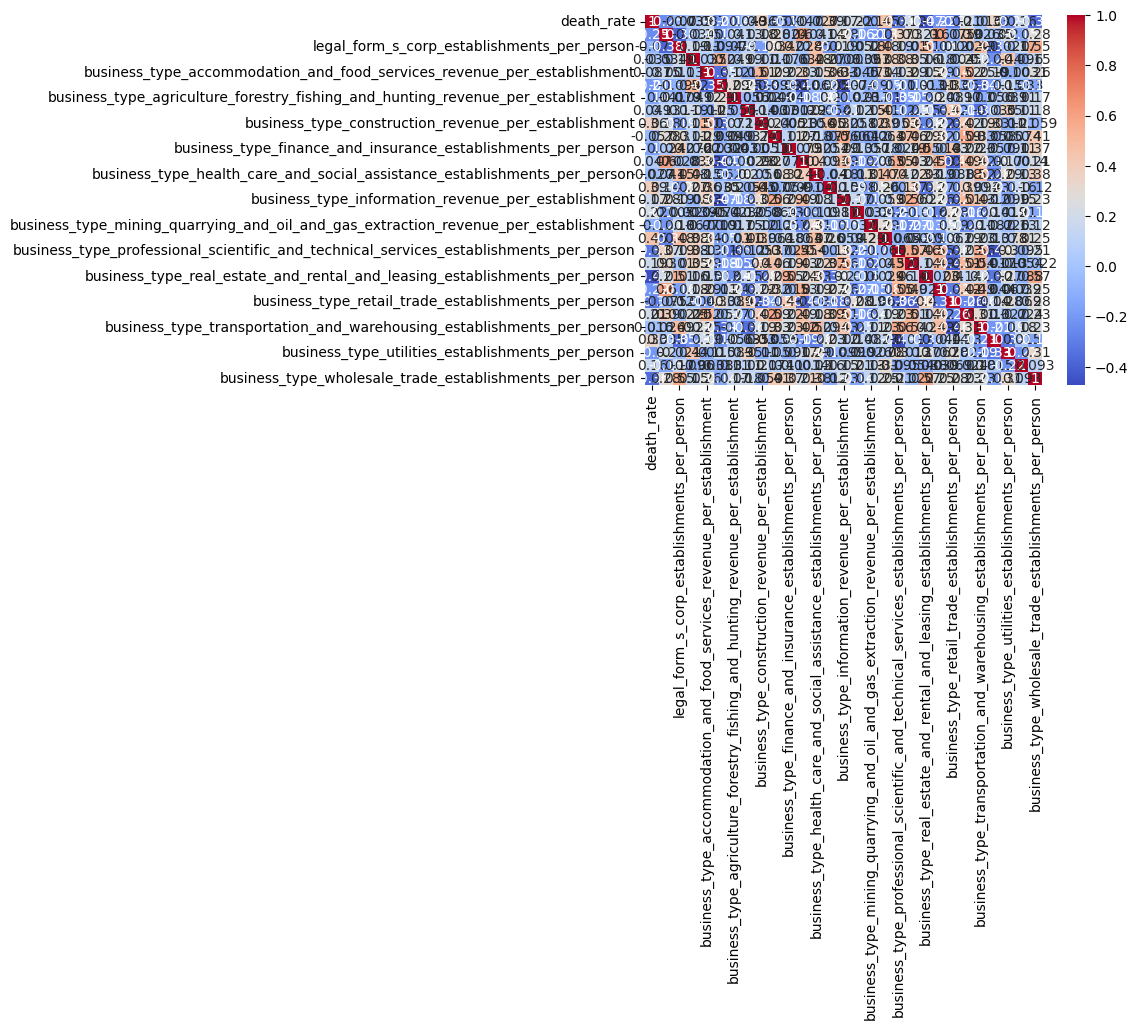

In [360]:
threshold = 0.6  # Set the threshold for collinearity

heart_disease_df = frames_by_cause_dict["Heart disease"]

candidate_feature_list = [x for x in heart_disease_df.columns if is_feature(x)]
non_collinear_feature_list = get_non_collinear_features(
    frame=heart_disease_df,
    feature_list=candidate_feature_list,
    threshold=threshold,
)
heart_disease_df = heart_disease_df[["death_rate"] + non_collinear_feature_list]
correlation_matrix = heart_disease_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

In [361]:
# Now that we have removed collinearity ...

X_column_list = list(heart_disease_df.columns)

ols_formula = "death_rate ~ "
ols_formula += " + ".join(X_column_list)
ordinary_least_square = ols(formula=ols_formula, data=heart_disease_df)
ordinary_least_square.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             death_rate   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.090e+28
Date:                Fri, 26 Apr 2024   Prob (F-statistic):          3.07e-290
Time:                        17:43:47   Log-Likelihood:                 1412.3
No. Observations:                  51   AIC:                            -2765.
Df Residuals:                      21   BIC:                            -2707.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
==========================================================================================================================================================
                                                                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                              -7.461e-14   1.55e-12     -0.048      0.962    -3.3e-12    3.15e-12
death_rate                                                                                 1.0000   4.55e-15    2.2e+14      0.000       1.000       1.000
legal_form_individual_proprietor_revenue_per_establishment                             -1.137e-13   1.04e-12     -0.109      0.914   -2.28e-12    2.05e-12
legal_form_s_corp_establishments_per_person                                            -2.665e-13   3.07e-12     -0.087      0.932   -6.65e-12    6.12e-12
business_type_accommodation_and_food_services_establishments_per_person                 3.183e-12   1.29e-11      0.246      0.808   -2.37e-11    3.01e-11
business_type_accommodation_and_food_services_revenue_per_establishment                -6.395e-14   3.92e-13     -0.163      0.872    -8.8e-13    7.52e-13
business_type_agriculture_forestry_fishing_and_hunting_establishments_per_person       -4.974e-13   2.57e-12     -0.193      0.848   -5.84e-12    4.85e-12
business_type_agriculture_forestry_fishing_and_hunting_revenue_per_establishment        3.908e-14   5.46e-13      0.072      0.944    -1.1e-12    1.17e-12
business_type_construction_establishments_per_person                                    2.842e-14   1.39e-12      0.020      0.984   -2.87e-12    2.92e-12
business_type_construction_revenue_per_establishment                                    2.842e-14   6.77e-13      0.042      0.967   -1.38e-12    1.44e-12
business_type_educational_services_revenue_per_establishment                            -6.75e-14   8.14e-13     -0.083      0.935   -1.76e-12    1.63e-12
business_type_finance_and_insurance_establishments_per_person                           1.705e-13   5.61e-12      0.030      0.976   -1.15e-11    1.18e-11
business_type_finance_and_insurance_revenue_per_establishment                           4.263e-14    1.3e-12      0.033      0.974   -2.66e-12    2.75e-12
business_type_health_care_and_social_assistance_establishments_per_person               2.558e-13   2.51e-12      0.102      0.920   -4.97e-12    5.48e-12
business_type_health_care_and_social_assistance_revenue_per_establishment               4.619e-14   4.02e-13      0.115      0.910   -7.89e-13    8.81e-13
business_type_information_revenue_per_establishment                                     5.684e-14    8.3e-13      0.069      0.946   -1.67e-12    1.78e-12
business_type_mining_quarrying_and_oil_and_gas_extraction_establishments_per_person    -5.684e-13    3.2e-12     -0.178      0.861   -7.22

### Overfitting/collinearity
It looks like we are still somewhat collinear, and we are probably overfitting, let's choose the most promising (based on P-score) five features.

In [362]:
refined_column_list = [
    "business_type_agriculture_forestry_fishing_and_hunting_revenue_per_establishment",
    "business_type_mining_quarrying_and_oil_and_gas_extraction_establishments_per_person",
    "business_type_professional_scientific_and_technical_services_establishments_per_person",
    "business_type_professional_scientific_and_technical_services_revenue_per_establishment",
    "business_type_retail_trade_revenue_per_establishment",
]

ols_formula = "death_rate ~ "
ols_formula += " + ".join(refined_column_list)
ordinary_least_square = ols(formula=ols_formula, data=heart_disease_df)
model = ordinary_least_square.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             death_rate   R-squared:                       0.433
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     6.876
Date:                Fri, 26 Apr 2024   Prob (F-statistic):           7.65e-05
Time:                        17:43:47   Log-Likelihood:                -227.68
No. Observations:                  51   AIC:                             467.4
Df Residuals:                      45   BIC:                             479.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==========================================================================================================================================================
                                                                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                144.8794     28.183      5.141      0.000      88.116     201.643
business_type_agriculture_forestry_fishing_and_hunting_revenue_per_establishment         -40.2958     14.238     -2.830      0.007     -68.973     -11.619
business_type_mining_quarrying_and_oil_and_gas_extraction_establishments_per_person      165.2460    118.039      1.400      0.168     -72.497     402.989
business_type_professional_scientific_and_technical_services_establishments_per_person  -136.4254     28.541     -4.780      0.000    -193.910     -78.941
business_type_professional_scientific_and_technical_services_revenue_per_establishment    83.2346     29.605      2.812      0.007      23.607     142.862
business_type_retail_trade_revenue_per_establishment                                      55.7840     32.552      1.714      0.093      -9.780     121.348
==============================================================================
Omnibus:                        1.486   Durbin-Watson:                   1.669
Prob(Omnibus):                  0.476   Jarque-Bera (JB):                1.321
Skew:                           0.242   Prob(JB):                        0.517
Kurtosis:                       2.378   Cond. No.                         70.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Impacts of the selected features

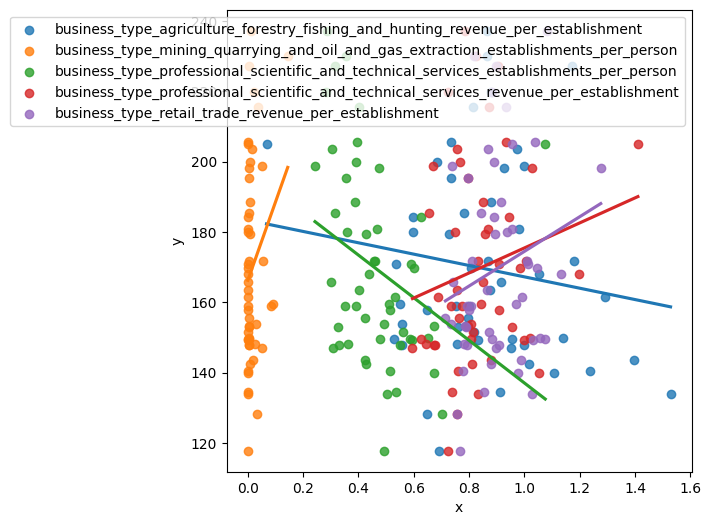

In [363]:
fig, ax = plt.subplots(figsize=(6, 6))
for feature in refined_column_list:
    sns.regplot(x=feature, y="death_rate", data=heart_disease_df, fit_reg=True, ci=None, ax=ax, label=feature)
ax.set(ylabel='y', xlabel='x')
ax.legend()

<a id="heart_disease_linear_regression_conclusion"></a>
#### Conclusions
I'm going to ignore _business_type_mining_quarrying_and_oil_and_gas_extraction_establishments_per_person_ because the P value was pretty high.

- Positive correlation with revenue per professional, scientific and technical services establishment.
- Positive correlation with revenue per retail establishment.
- Inverse correlation with the revenue per agriculture, forestry, fishing and hunting establishment.
- Inverse correlation with the number of nonemployee professional, scientific and technical establishments per person

In other words, move to a state with good revenue from professional/scientific/technical services and retail establishments, and maybe avoid states with more revenue from agriculture, forestry, fishing and hunting establishment establishments.

#### Verifying assumptions
At the beginning we stated assumptions for linear regression, so let's check:
* The residuals are at least somewhat normally distributed ...
* Our assumption of homoscedasticity is solid

Text(0.5, 0, 'Residual Value')

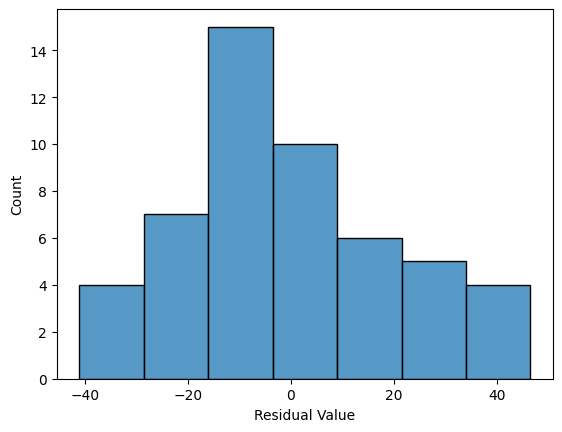

In [364]:
residuals = model.resid
fig = sns.histplot(residuals)
fig.set_xlabel("Residual Value")

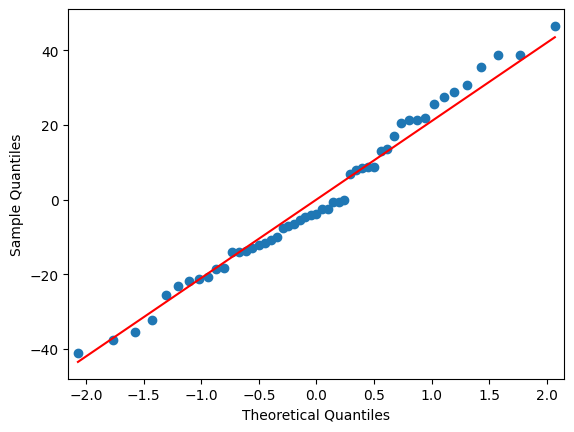

In [365]:
fig = qqplot(model.resid, line='s')
plt.show()

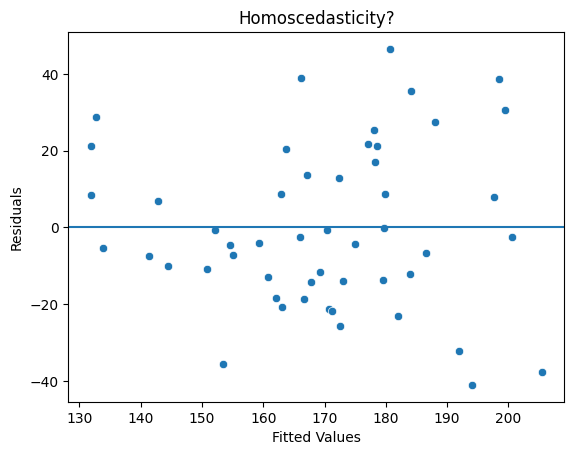

In [366]:
fitted_values = model.predict(heart_disease_df)
fig = sns.scatterplot(x=fitted_values, y=residuals)
fig.axhline(0)  # Reference line

fig.set_xlabel("Fitted Values")
fig.set_ylabel("Residuals")
fig.set_title("Homoscedasticity?")

plt.show()

## Bayes analysis
### Categorization of data
We will make the death rate a categorical.

Distribution plots will help us decide how to make the cuts.

Rice's rule suggests 7 bins.


(array([ 2.,  6., 13., 10.,  5.,  4.,  6.,  2.,  3.]),
 array([117.7875    , 131.05555556, 144.32361111, 157.59166667,
        170.85972222, 184.12777778, 197.39583333, 210.66388889,
        223.93194444, 237.2       ]),
 <BarContainer object of 9 artists>)

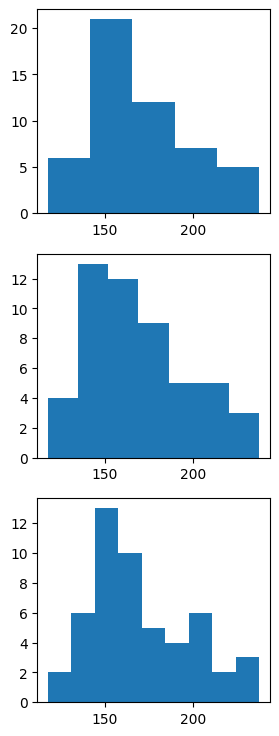

In [367]:
number_of_observations = heart_disease_df["death_rate"].nunique()
# Rice's rule
suggested_bin_count = int(math.cbrt(number_of_observations)*2)
print(f"Rice's rule suggests {suggested_bin_count} bins.")
fig, axs = plt.subplots(
    nrows=3,
    figsize=(3*1, 3*3)
)
axs[0].hist(heart_disease_df["death_rate"], bins=suggested_bin_count-2)
axs[1].hist(heart_disease_df["death_rate"], bins=suggested_bin_count)
axs[2].hist(heart_disease_df["death_rate"], bins=suggested_bin_count+2)


### Binning conclusion
I like 5, but use [cut](https://pandas.pydata.org/docs/reference/api/pandas.cut.html) to make them contain the same number of rows.

In [368]:
# XXSMALL = "xx-small"
XSMALL = "x-small"
SMALL = "small"
MEDIUM = "medium"
LARGE = "large"
XLARGE = "x-large"
# XXLARGE = "xx-large"

label_list = (XSMALL, SMALL, MEDIUM, LARGE, XLARGE)

bayes_df = heart_disease_df.copy()
bayes_df["death_rate_category"] = pd.cut(bayes_df["death_rate"], bins=5, include_lowest=True, labels=label_list)
bayes_df.drop(columns=["death_rate"], inplace=True)
y = bayes_df["death_rate_category"]
X = bayes_df.copy()
X.drop(columns=["death_rate_category"], inplace=True)


### Asymmetric classification
A straight Bayes analysis is not appropriate if one result dominates over the other, say, 90% of the time the correct classification is A and 10% is B.

Because of the cutting we did earlier this is not a concern.

### Training/testing

In [369]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

### Fitting

In [370]:
naive_bayes = GaussianNB()
naive_bayes.fit(X_train, y_train)
y_predicates = naive_bayes.predict(X_test)

accuracy = accuracy_score(
    y_test, y_predicates,
)
precision = precision_score(
    y_test, y_predicates,
    average='macro',
    labels=label_list,
)
recall = recall_score(
    y_test, y_predicates,
    average='macro',
    labels=label_list,
)
f1 = f1_score(
    y_test, y_predicates,
    average='macro',
    labels=label_list,
)
print(f"Accuracy : {accuracy:.3f}")
print(f"Precision: {precision:.3f}") 
print(f"Recall   : {recall:.3f}") 
print(f"F1 Score : {f1:.3f}") 

Accuracy : 0.231
Precision: 0.075
Recall   : 0.120
F1 Score : 0.092


/home/jason/PycharmProjects/data_science/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jason/PycharmProjects/data_science/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<a id="bayes_1"></a>
### Analysis
Those are terrible scores, worse than guessing.

Instead of focusing on heart disease, let's do all diseases.
And let's do three categories instead of five.

In [371]:
label_list = (SMALL, MEDIUM, LARGE)
for cause_name, frame in frames_by_cause_dict.items():
    frame["death_rate_category"] = pd.cut(frame["death_rate_normalized"], bins=3, include_lowest=True, labels=label_list)

heart_disease_df = frames_by_cause_dict["Heart disease"]
heart_disease_df["death_rate_category"].head(5)

204     small
205    medium
206     large
207     small
208     small
Name: death_rate_category, dtype: category
Categories (3, object): ['small' < 'medium' < 'large']

In [372]:
bayes_df = pd.concat(frames_by_cause_dict.values(), axis=0)
drop_column_list = [
    "death_rate",
    "death_rate_normalized",
    "state_key",
    "establishment_count",
    "revenue_in_thousands",
    "revenue_per_person",
    "population",
    "population_scaled",
    "state_key_scaled",
]
bayes_df.drop(columns=drop_column_list, inplace=True)
bayes_df

,establishment_count_scaled,revenue_in_thousands_scaled,establishments_per_person_scaled,revenue_per_person_scaled,revenue_per_establishment_scaled,legal_form_c_corp_establishments_per_person,legal_form_c_corp_revenue_per_establishment,legal_form_individual_proprietor_establishments_per_person,legal_form_individual_proprietor_revenue_per_establishment,legal_form_partnership_establishments_per_person,...,business_type_real_estate_and_rental_and_leasing_revenue_per_establishment,business_type_retail_trade_establishments_per_person,business_type_retail_trade_revenue_per_establishment,business_type_transportation_and_warehousing_establishments_per_person,business_type_transportation_and_warehousing_revenue_per_establishment,business_type_utilities_establishments_per_person,business_type_utilities_revenue_per_establishment,business_type_wholesale_trade_establishments_per_person,business_type_wholesale_trade_revenue_per_establishment,death_rate_category
0,0.099266,0.093257,4.034765,3.792305,14.769033,0.152005,4.527146,3.035137,1.180676,0.646943,...,0.677056,0.405765,0.970442,0.150432,1.136622,0.004010,0.647892,0.058899,1.107499,medium
1,0.118990,0.096941,4.485893,3.656388,13.939559,0.044856,3.515870,3.997145,1.409454,0.317493,...,0.838036,0.372706,0.784850,0.118668,0.907610,0.008679,0.626771,0.061048,1.167174,large
2,0.118683,0.111430,3.955955,3.715968,16.739990,0.058232,4.620540,3.544528,1.175650,0.280776,...,1.019488,0.121429,0.954979,0.471271,0.912004,0.002644,0.712351,0.018250,1.279470,small
3,0.109882,0.097620,3.533452,3.140637,14.401345,0.027187,4.351044,3.143003,1.049728,0.260921,...,0.880360,0.316602,0.986950,0.182969,0.919840,0.001866,0.513574,0.034466,0.900660,small
4,0.107016,0.100730,3.303506,3.110932,14.288669,0.027233,3.436284,2.755440,1.275890,0.423606,...,0.879698,0.391356,0.895772,0.210101,1.122934,0.002031,1.046414,0.044075,0.956260,large
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,1.642608,1.507819,3.018361,2.772002,15.306140,0.027587,4.290704,2.626389,1.359378,0.252956,...,0.849936,0.296384,0.892937,0.238479,1.039105,0.001991,0.843433,0.047787,1.172121,medium
506,3.388345,3.395193,4.097352,4.107592,15.510013,0.142335,4.109896,3.338289,1.269360,0.324203,...,1.031175,0.278354,0.890067,0.445348,0.793400,0.002056,0.971753,0.075288,1.247874,small
507,4.343588,3.591760,4.757457,3.935870,15.772944,0.148240,4.558704,3.847684,0.944597,0.289256,...,0.674140,0.321768,0.870698,0.447462,0.911380,0.002002,0.855001,0.084754,1.141346,medium
508,4.641799,4.320661,3.765865,3.507000,19.744383,0.044132,5.950895,3.387737,1.312604,0.222543,...,0.944199,0.308354,1.009625,0.329986,1.359840,0.002927,1.061917,0.053823,1.345816,small


### Training set, testing set, fit

In [373]:
y = bayes_df["death_rate_category"]
X = bayes_df.copy()
X.drop(columns=["death_rate_category"], inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

naive_bayes = GaussianNB()
naive_bayes.fit(X_train, y_train)
y_predicates = naive_bayes.predict(X_test)

accuracy = accuracy_score(
    y_test, y_predicates,
)
precision = precision_score(
    y_test, y_predicates,
    average='macro',
    labels=label_list,
)
recall = recall_score(
    y_test, y_predicates,
    average='macro',
    labels=label_list,
)
f1 = f1_score(
    y_test, y_predicates,
    average='macro',
    labels=label_list,
)
print(f"Accuracy : {accuracy:.3f}")
print(f"Precision: {precision:.3f}") 
print(f"Recall   : {recall:.3f}") 
print(f"F1 Score : {f1:.3f}") 

Accuracy : 0.484
Precision: 0.408
Recall   : 0.406
F1 Score : 0.405


<a id="bayes_2"></a>
### Analysis, part II
Better than part I, but still worse than guessing.

## Decision trees
XGBoost expects the `y`s to be numeric.

There are multiple ways to do this.

In [399]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
y_train.value_counts()

death_rate_category
medium    185
small     109
large      88
Name: count, dtype: int64

In [400]:
# Method 1
# def convert_category_to_numeric(category: str) -> int:
#     if isinstance(category, int):
#         return category
#     if category == SMALL:
#         return 0
#     if category == MEDIUM:
#         return 1
#     if category == LARGE:
#         return 2
#     raise Exception("Programming error.")

# y_train = y_train.apply(convert_category_to_numeric)
# y_test = y_test.apply(convert_category_to_numeric)


# Method 2
# y_train.replace(SMALL , 0, inplace=True)
# y_train.replace(MEDIUM, 1, inplace=True)
# y_train.replace(LARGE , 2, inplace=True)
# y_test.replace(SMALL , 0, inplace=True)
# y_test.replace(MEDIUM, 1, inplace=True)
# y_test.replace(LARGE , 2, inplace=True)


# Method 3
mappings = {
    SMALL: 0,
    MEDIUM: 1,
    LARGE: 2,
}

y_train = y_train.map(mappings)
y_test = y_test.map(mappings)
y_train.value_counts()

death_rate_category
1    185
0    109
2     88
Name: count, dtype: int64

In [428]:
def display_xgb_results(classifier: XGBClassifier) -> None:
    results = classifier.evals_result()
    epochs = len(results['validation_0']['mlogloss'])
    x_axis = range(0, epochs)
    
    # xgboost 'mlogloss' plot
    fig, ax = plt.subplots(figsize=(9,5))
    ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
    ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
    ax.legend()
    plt.ylabel('mlogloss')
    plt.title('GridSearchCV XGBoost mlogloss')
    plt.show()
    
    # xgboost 'merror' plot
    fig, ax = plt.subplots(figsize=(9,5))
    ax.plot(x_axis, results['validation_0']['merror'], label='Train')
    ax.plot(x_axis, results['validation_1']['merror'], label='Test')
    ax.legend()
    plt.ylabel('merror')
    plt.title('GridSearchCV XGBoost merror')
    plt.show()
    
    ## ---------- Model Classification Report ----------
    ## get predictions and create model quality report
    
    y_pred = xgb_clf.predict(X_test)
    
    print('\n------------------ Confusion Matrix -----------------\n')
    model_pred = classifier.predict(X_test)
    cm = confusion_matrix(y_test, model_pred, labels=classifier.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=classifier.classes_)
    
    disp.plot()
    plt.show()
    
    print('\nAccuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
    print('Balanced Accuracy: {:.2f}\n'.format(balanced_accuracy_score(y_test, y_pred)))
    
    print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
    print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
    print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))
    
    print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
    print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
    print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))
    
    print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
    print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
    print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))
    
    print('\n--------------- Classification Report ---------------\n')
    print(classification_report(y_test, y_pred))

    # plot_importance(classifier.best_estimator_)

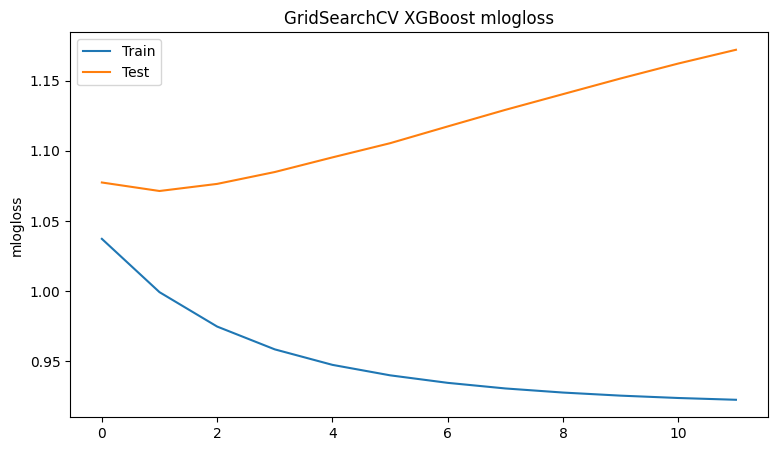

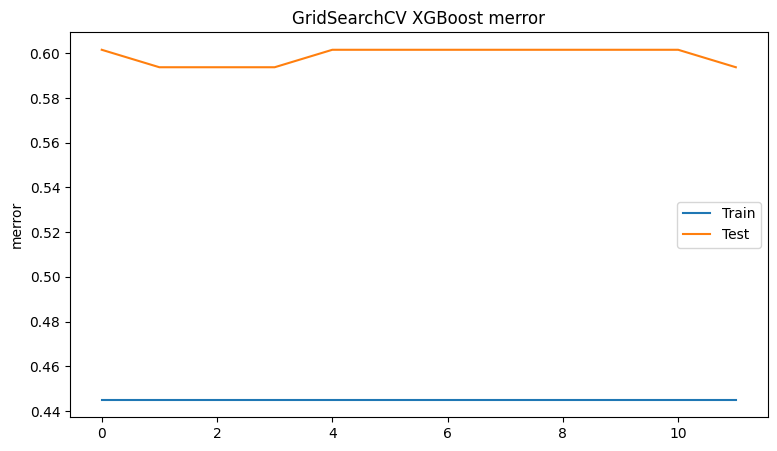


------------------ Confusion Matrix -----------------



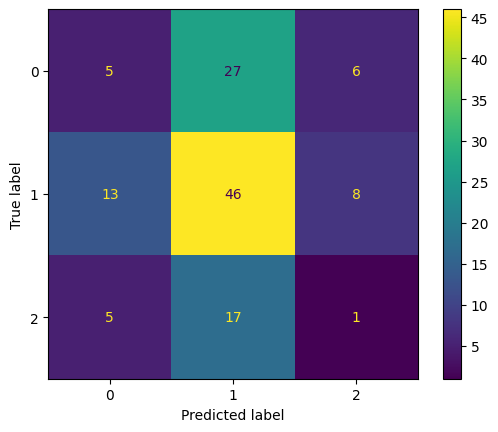


Accuracy: 0.41
Balanced Accuracy: 0.29

Micro Precision: 0.41
Micro Recall: 0.41
Micro F1-score: 0.41

Macro Precision: 0.27
Macro Recall: 0.29
Macro F1-score: 0.27

Weighted Precision: 0.34
Weighted Recall: 0.41
Weighted F1-score: 0.36

--------------- Classification Report ---------------

              precision    recall  f1-score   support

           0       0.22      0.13      0.16        38
           1       0.51      0.69      0.59        67
           2       0.07      0.04      0.05        23

    accuracy                           0.41       128
   macro avg       0.27      0.29      0.27       128
weighted avg       0.34      0.41      0.36       128



In [429]:
## ---------- XGBoost model v1 ----------
## base run of model with default hyperparameters

xgb_clf = XGBClassifier(objective='multi:softmax', 
                            num_class=3, 
                            missing=1, 
                            early_stopping_rounds=10, 
                            eval_metric=['merror','mlogloss'], 
                            seed=42)
xgb_clf.fit(X_train, 
            y_train,
            verbose=0, # set to 1 to see xgb training round intermediate results
            eval_set=[(X_train, y_train), (X_test, y_test)])

display_xgb_results(xgb_clf)

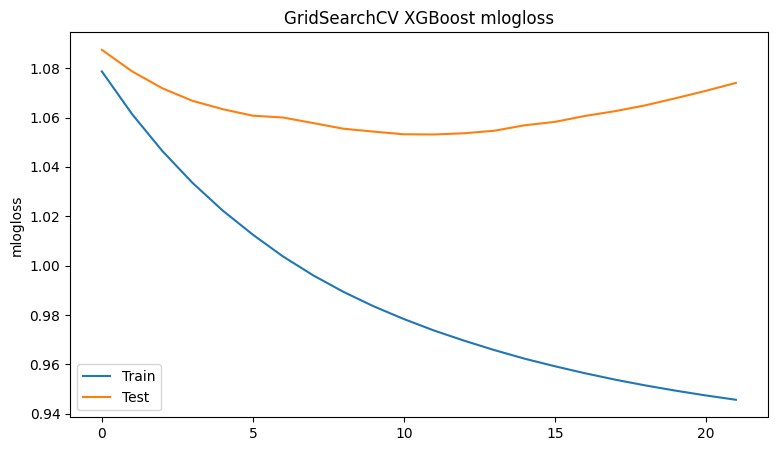

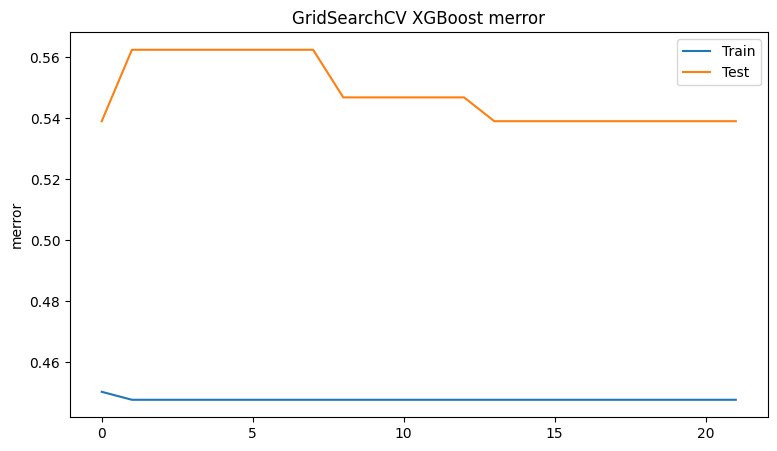


------------------ Confusion Matrix -----------------

[[ 5 28  5]
 [12 52  3]
 [ 3 19  1]]

Accuracy: 0.45
Balanced Accuracy: 0.32

Micro Precision: 0.45
Micro Recall: 0.45
Micro F1-score: 0.45

Macro Precision: 0.30
Macro Recall: 0.32
Macro F1-score: 0.29

Weighted Precision: 0.37
Weighted Recall: 0.45
Weighted F1-score: 0.39

--------------- Classification Report ---------------

              precision    recall  f1-score   support

           0       0.25      0.13      0.17        38
           1       0.53      0.78      0.63        67
           2       0.11      0.04      0.06        23

    accuracy                           0.45       128
   macro avg       0.30      0.32      0.29       128
weighted avg       0.37      0.45      0.39       128



In [412]:
## ---------- XGBoost model v2 ----------
## second run of model with "optimized" hyperparameters 

# declaring and fitting xgb classifier
xgb_clf = XGBClassifier(objective='multi:softmax', 
                            num_class=3, 
                            missing=1,
                            gamma=0, # default gamma value
                            learning_rate=0.1,
                            max_depth=3,
                            reg_lambda=1, # default L2 value
                            subsample=1, # default subsample value
                            colsample_bytree=1, # default colsample_bytree value
                            early_stopping_rounds=10,
                            eval_metric=['merror','mlogloss'],
                            seed=42)
xgb_clf.fit(X_train, 
            y_train,
            verbose=0, # set to 1 to see xgb training round intermediate results
            #sample_weight=sample_weights, # class weights to combat unbalanced 'target'
            eval_set=[(X_train, y_train), (X_test, y_test)])

display_xgb_results(xgb_clf)

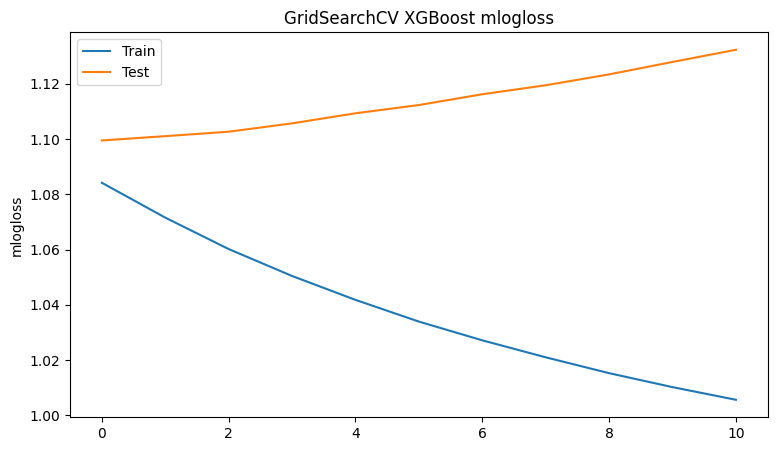

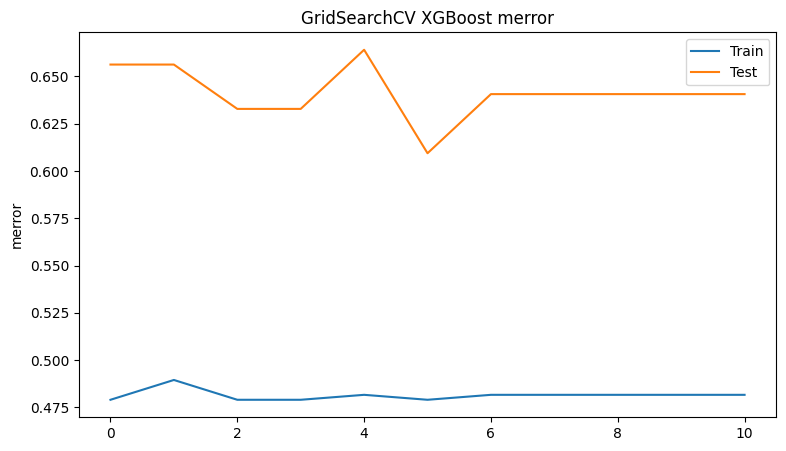


------------------ Confusion Matrix -----------------

[[12 12 14]
 [24 28 15]
 [ 9 10  4]]

Accuracy: 0.34
Balanced Accuracy: 0.30

Micro Precision: 0.34
Micro Recall: 0.34
Micro F1-score: 0.34

Macro Precision: 0.32
Macro Recall: 0.30
Macro F1-score: 0.30

Weighted Precision: 0.39
Weighted Recall: 0.34
Weighted F1-score: 0.36

--------------- Classification Report ---------------

              precision    recall  f1-score   support

           0       0.27      0.32      0.29        38
           1       0.56      0.42      0.48        67
           2       0.12      0.17      0.14        23

    accuracy                           0.34       128
   macro avg       0.32      0.30      0.30       128
weighted avg       0.39      0.34      0.36       128



In [417]:
## ---------- XGBoost model v3 ----------
## third run of model with "optimized" hyperparameters and
## attempting to treat unbalanced target classes

# balancing 'target' class weights
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train)

# declaring and fitting xgb classifier
xgb_clf = XGBClassifier(objective='multi:softmax', 
                            num_class=3, 
                            missing=1,
                            gamma=0, # default gamma value
                            learning_rate=0.1,
                            max_depth=5, # re-optimized from v2
                            reg_lambda=1, # default L2 value
                            #subsample=0.8, # tried but not ideal
                            #colsample_bytree=0.3, # tried but not ideal
                            early_stopping_rounds=10,
                            eval_metric=['merror','mlogloss'],
                            seed=42)
xgb_clf.fit(X_train, 
            y_train,
            verbose=0, # set to 1 to see xgb training round intermediate results
            sample_weight=sample_weights, # class weights to combat unbalanced 'target'
            eval_set=[(X_train, y_train), (X_test, y_test)])

display_xgb_results(xgb_clf)

<a id="xgboost"></a>
### Analysis
Not predictive.

## Linear regression again
We will combine all causes of death, which will give us ten times more data points

In [420]:
df["cause"].nunique()

10